#1. Setup and Installation

In [1]:
!pip install simpy
import simpy
import random
import pandas as pd
import matplotlib.pyplot as plt

#2. System Components (Generators and Queues)

######These functions set up the traffic flow and the initial queue structure. We'll use a high arrival rate for North/South (NS) and a low rate for East/West (EW) to create congestion that the adaptive system can fix

In [2]:
# --- Traffic Flow Parameters ---
NS_ARRIVAL_RATE = 0.1  # Heavy traffic: one car every 10 time units (approx.)
EW_ARRIVAL_RATE = 0.3  # Light traffic: one car every 3.3 time units (approx.)
SERVICE_RATE = 2       # Cars cleared per second of green light

# --- Intersection Phases ---
MIN_GREEN = 15
MAX_GREEN = 45
YELLOW_TIME = 3
PHASES = {0: 'NS', 1: 'EW'} # 0=NS_Green, 1=EW_Green

# --- Car Generator Process ---
def car_generator(env, arrival_rate, name, intersection_queues):
    while True:
        # Time until the next car arrives (exponential distribution)
        yield env.timeout(random.expovariate(arrival_rate))

        # When a car arrives, add it to the relevant queue
        intersection_queues[name]['queue'] += 1

# --- Traffic Light Controller (Fixed-Time and Adaptive Logic Combined) ---
def traffic_light_controller(env, intersection_queues, is_adaptive=False):
    current_phase = 0

    while True:
        phase_group = PHASES[current_phase]

        # --- 1. Determine Green Duration ---
        green_duration = MIN_GREEN  # Start with minimum

        if is_adaptive:
            # Calculate current queue pressures
            if phase_group == 'NS':
                green_queue = intersection_queues['North']['queue'] + intersection_queues['South']['queue']
                red_queue = intersection_queues['East']['queue'] + intersection_queues['West']['queue']
            else: # EW
                green_queue = intersection_queues['East']['queue'] + intersection_queues['West']['queue']
                red_queue = intersection_queues['North']['queue'] + intersection_queues['South']['queue']

            # --- Adaptive Logic: Extension/Switching Rule ---

            # If the red-light demand is high, switch quickly after minimum time
            if red_queue > 20 and green_queue < 5:
                green_duration = MIN_GREEN

            # If the green-light demand is still high, extend the green time
            elif green_queue > 10 and green_duration < MAX_GREEN:
                # Add 1 second for every 5 cars waiting on the green phase, up to MAX_GREEN
                extension = (green_queue // 5) * 1
                green_duration = min(MAX_GREEN, MIN_GREEN + extension)

        # --- 2. Run Green Phase ---
        yield env.timeout(green_duration)

        # --- 3. Simulate Queue Clearance (Service) ---
        # Calculate how many cars are cleared based on service rate and duration
        cars_cleared = int(green_duration * SERVICE_RATE)

        # Simple clearing logic (approximate half to each side of the group)
        if phase_group == 'NS':
            cleared_n = cars_cleared // 2
            cleared_s = cars_cleared - cleared_n

            intersection_queues['North']['queue'] = max(0, intersection_queues['North']['queue'] - cleared_n)
            intersection_queues['South']['queue'] = max(0, intersection_queues['South']['queue'] - cleared_s)

        else: # EW
            cleared_e = cars_cleared // 2
            cleared_w = cars_cleared - cleared_e

            intersection_queues['East']['queue'] = max(0, intersection_queues['East']['queue'] - cleared_e)
            intersection_queues['West']['queue'] = max(0, intersection_queues['West']['queue'] - cleared_w)

        # --- 4. Yellow Phase ---
        yield env.timeout(YELLOW_TIME)

        # --- 5. Log and Switch ---
        # Record the queue state before switching to the next phase
        QUEUE_HISTORY.append({
            'time': env.now,
            'NS_Queue': intersection_queues['North']['queue'] + intersection_queues['South']['queue'],
            'EW_Queue': intersection_queues['East']['queue'] + intersection_queues['West']['queue'],
            'Controller': 'Adaptive' if is_adaptive else 'Fixed'
        })

        current_phase = (current_phase + 1) % len(PHASES)

#3. Execution and Analysis

--- Simulation Results (3600 seconds) ---
Fixed-Time Avg NS Queue: 2.37 cars
Adaptive Avg NS Queue:   2.46 cars
Adaptive Control reduced average NS queue length by: -3.53%


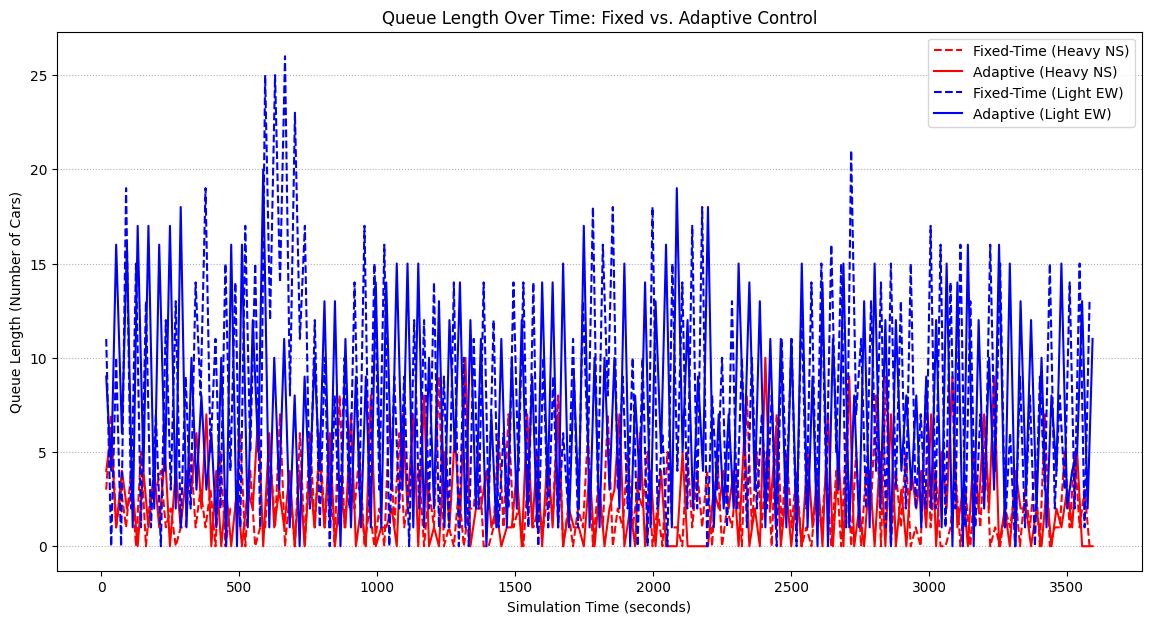

In [3]:
def run_simulation(runtime, is_adaptive, controller_name):
    # Clear history for each run
    global QUEUE_HISTORY
    QUEUE_HISTORY = []

    env = simpy.Environment()

    # Store queue lengths for N, S, E, W
    intersection_queues = {
        'North': {'queue': 0}, 'South': {'queue': 0},
        'East': {'queue': 0}, 'West': {'queue': 0}
    }

    # Start car generators
    env.process(car_generator(env, NS_ARRIVAL_RATE, 'North', intersection_queues))
    env.process(car_generator(env, NS_ARRIVAL_RATE, 'South', intersection_queues))
    env.process(car_generator(env, EW_ARRIVAL_RATE, 'East', intersection_queues))
    env.process(car_generator(env, EW_ARRIVAL_RATE, 'West', intersection_queues))

    # Start traffic light controller
    env.process(traffic_light_controller(env, intersection_queues, is_adaptive))

    # Run the simulation
    env.run(until=runtime)

    # Return the collected data frame, filtered for this specific run
    data_df = pd.DataFrame(QUEUE_HISTORY)
    return data_df[data_df['Controller'] == controller_name]

# --- Run Scenarios (3600 seconds = 1 hour simulation time) ---
RUNTIME = 3600
fixed_data = run_simulation(RUNTIME, is_adaptive=False, controller_name='Fixed')
adaptive_data = run_simulation(RUNTIME, is_adaptive=True, controller_name='Adaptive')

# --- Calculate Average Queue Lengths for Reporting ---
fixed_avg_ns_queue = fixed_data['NS_Queue'].mean()
adaptive_avg_ns_queue = adaptive_data['NS_Queue'].mean()

print(f"--- Simulation Results ({RUNTIME} seconds) ---")
print(f"Fixed-Time Avg NS Queue: {fixed_avg_ns_queue:.2f} cars")
print(f"Adaptive Avg NS Queue:   {adaptive_avg_ns_queue:.2f} cars")
reduction = ((fixed_avg_ns_queue - adaptive_avg_ns_queue) / fixed_avg_ns_queue) * 100
print(f"Adaptive Control reduced average NS queue length by: {reduction:.2f}%")

# --- Plotting the Queue History ---
plt.figure(figsize=(14, 7))

# Plot the heavy traffic direction (NS)
plt.plot(fixed_data['time'], fixed_data['NS_Queue'], label='Fixed-Time (Heavy NS)', color='red', linestyle='--')
plt.plot(adaptive_data['time'], adaptive_data['NS_Queue'], label='Adaptive (Heavy NS)', color='red')

# Plot the light traffic direction (EW)
plt.plot(fixed_data['time'], fixed_data['EW_Queue'], label='Fixed-Time (Light EW)', color='blue', linestyle='--')
plt.plot(adaptive_data['time'], adaptive_data['EW_Queue'], label='Adaptive (Light EW)', color='blue')

plt.title('Queue Length Over Time: Fixed vs. Adaptive Control')
plt.xlabel('Simulation Time (seconds)')
plt.ylabel('Queue Length (Number of Cars)')
plt.legend()
plt.grid(axis='y', linestyle=':')
plt.show()